# Cylindrical Analysis


In [5]:
using MHDFlows
using PyPlot
using HDF5,FFTW,FourierFlows
using LinearAlgebra: mul!, ldiv!
using Statistics
using PyCall,LazCh5
glob = pyimport("glob2")

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


PyObject <module 'glob2' from '/usr/local/lib/python3.6/dist-packages/glob2/__init__.py'>

In [6]:
(256/170)^3

3.4148617952371256

In [7]:
#get the Uθ and Ur
function xy_to_polar(ux,uy;L=2π)
#=
  Function for converting x-y vector to r-θ vector, using linear transform
    [x']  =  [cos(θ) -rsin(θ)][r']
    [y']     [sin(θ)  rcos(θ)][θ']
    So e_r =  cosθ ̂i + sinθ ̂j
       e_θ = -sinθ ̂j + cosθ ̂j
=#    
  nx,ny,nz = size(ux);  
  dev  = CPU();
  Lx = Ly = L;
  T  = Float32;
  grid = TwoDGrid(dev, nx, Lx, ny, Ly; T=T)
  Ur = zeros(nx,ny,nz);
  Uθ = zeros(nx,ny,nz);
  for j ∈ 1:ny, i ∈ 1:nz
    r = sqrt(grid.x[i]^2+grid.y[j]^2);
    θ = atan(grid.y[j],grid.x[i]) ;
    θ = isnan(θ) ? π/2 : θ;
    sinθ = sin(θ);
    cosθ = cos(θ);    
    Uθ[i,j,:] .= @. -sinθ*ux[i,j,:] + cosθ*uy[i,j,:];    
    Ur[i,j,:] .= @.  cosθ*ux[i,j,:] + sinθ*uy[i,j,:];    
  end
    return Ur,Uθ;
end

function Taylor_Couette_Cylindrical_Mask_Function(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    
    for k ∈ 1:nz, j ∈ 1:ny,i ∈ 1:nx
        xᵢ,yᵢ,zᵢ = x[i],y[j],z[k];
        Rᵢ       = √(xᵢ^2+yᵢ^2);
        # S = 0 if inside fluid domain while S = 1 in the solid domain 
        S[i,j,k] = (R₂ >= Rᵢ >= R₁) ?  0 : 1; 
    end    
    S
end

Taylor_Couette_Cylindrical_Mask_Function (generic function with 1 method)

In [313]:
ff = glob.glob("/mnt/c/data/MHD_Cylinder/P5DA__t_0000.h5");
f = h5open(ff[1],"r")
iv = read( f , "i_velocity",  ) ;
jv = read( f , "j_velocity",  ) ;
kv = read( f , "k_velocity",  ) ;
ib = read( f , "i_mag_field", ) ;
jb = read( f , "j_mag_field", ) ;
kb = read( f , "k_mag_field", ) ;
close(f)
T    = Float32;
Lx   = 2π
nx,ny,nz = size(iv)
gg = ThreeDGrid(nx,Lx, ny,Lx, nz, Lx,T = T);
χ =  Taylor_Couette_Cylindrical_Mask_Function(gg);
A = ones(size(χ)[1:2])
A[χ[:,:,1].>0].=NaN;

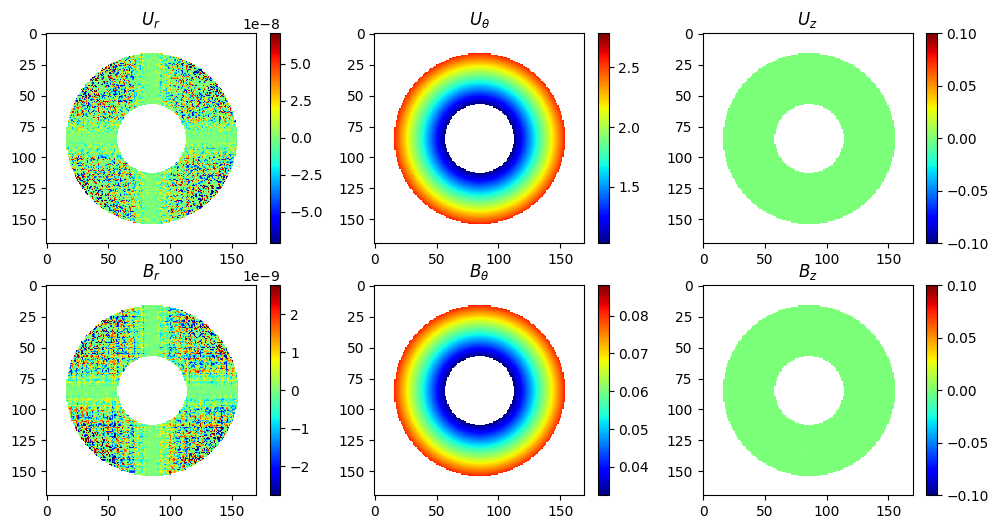

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb55d49cfd0>

In [314]:
Ur,Uθ = xy_to_polar(iv,jv);
figure(figsize=(12,6))
subplot(231);title(L"U_r")
Ur2D = (A.*Ur)[:,:,1];
m,σ = mean(Ur2D[.~isnan.(Ur2D)]),std(Ur2D[.~isnan.(Ur2D)]);
imshow(Ur2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(232);title(L"U_θ")
Uθ2D = (A.*Uθ)[:,:,1];
m,σ = mean(Uθ2D[.~isnan.(Uθ2D)]),std(Uθ2D[.~isnan.(Uθ2D)]);
imshow(Uθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()

subplot(233);title(L"U_z")
Uz2D = (A.*kv)[:,:,1];
m,σ = mean(Uz2D[.~isnan.(Uz2D)]),std(Uz2D[.~isnan.(Uz2D)]);
imshow(Uz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()


Br,Bθ = xy_to_polar(ib,jb);
subplot(234);title(L"B_r")
Br2D = (A.*Br)[:,:,50];
m,σ = mean(Br2D[.~isnan.(Br2D)]),std(Br2D[.~isnan.(Br2D)]);
imshow(Br2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(235);title(L"B_θ")
Bθ2D = (A.*Bθ)[:,:,50];
m,σ = mean(Bθ2D[.~isnan.(Bθ2D)]),std(Bθ2D[.~isnan.(Bθ2D)]);
imshow(Bθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(236);title(L"B_z")
Bz2D = (A.*kb)[:,:,50];
m,σ = mean(Bz2D[.~isnan.(Bz2D)]),std(Bz2D[.~isnan.(Bz2D)]);
imshow(Bz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()


In [257]:
mean((1 .- χ).*Br), mean((1 .- χ).*Bθ), mean(mean((1 .- χ).*kb))

(-3.864108112392689e-6, 0.01409605231974937, -0.00014300115f0)

In [174]:
mean((1 .- χ).*Br), mean((1 .- χ).*Bθ), mean(mean((1 .- χ).*kb))

(-1.5508618303451793e-12, 0.0269877534335202, 0.0f0)

In [175]:
mean((1 .- χ).*Br), mean((1 .- χ).*Bθ),mean(mean((1 .- χ).*kb))

(-1.5508618303451793e-12, 0.0269877534335202, 0.0f0)

In [176]:
N  = 170
dx = 2π/N
v  = π
dt = 0.3*dx/v/2.5e-3

1.4117647058823528

# Spectrum Analysis

In [216]:
function Spectralline3D(B1,Lx = 2π)
    
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    mul!(B1h, grid.rfftplan, B1); 
    B1h = abs.(B1h).^2
    Eₖ = zeros(round(Int,√(nx^2+ny^2+nz^2)));
    
    for i in 1:div(nz,2)+1, j in 1:ny, k in 1:nx
       x,y,z = grid.kr[i],grid.l[j],grid.m[k];
       rₖ    = round(Int,sqrt(x^2+y^2+z^2));
       Eₖ[rₖ+1] += B1h[i,j,k];
    end
    return collect(1:1:round(Int,√(nx^2+ny^2+nz^2))),Eₖ
end


Spectralline3D (generic function with 2 methods)

In [217]:
tot_KE =  (1 .-χ).*(iv.^2 .+ jv.^2 + kv.^2);
tot_ME =  (1 .-χ).*(ib.^2 .+ jb.^2 + kb.^2);

tot_KE[isnan.(tot_KE)].==0;
tot_ME[isnan.(tot_ME)].==0;

y_K,x = spectrallines3D(tot_KE);
y_M,x = spectrallines3D(tot_ME);

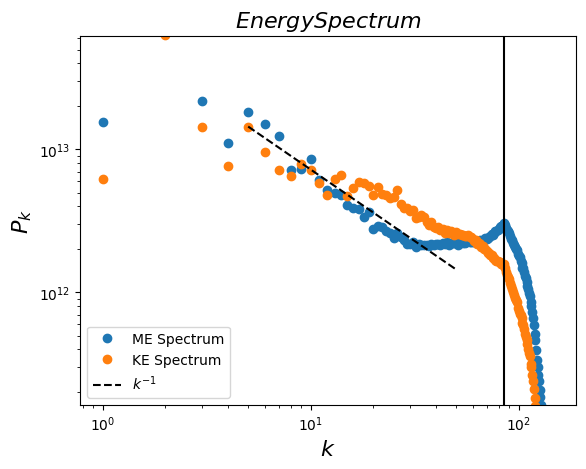

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb599828780>

In [258]:
#Comment: don't trust this result, as IC already inject k^{-2} spectrum

loglog(x,5*y_M,"o",label="ME Spectrum");
loglog(x,y_K,"o",label="KE Spectrum");
loglog(x[5:50],y_K[5]*x[5:50].^(-1)*x[5],"k--",label=L"k^{-1}")
ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
legend()
ylim(.1*y_K[80],10*y_K[1],)
plot([nx/2,nx/2],[0,10*y_K[1]],"k")

# Comparsion between Small Scale and Large Scale

In [259]:
ib,jb,kb = (1 .- χ).*ib,(1 .- χ).*jb,(1 .- χ).*kb;
iv,jv,kv = (1 .- χ).*iv,(1 .- χ).*jv,(1 .- χ).*kv;
ibL,jbL,kbL = ScaleDecomposition(ib,jb,kb;kf=[1,6],Lx = 2π);
ibS,jbS,kbS = ScaleDecomposition(ib,jb,kb;kf=[20,40],Lx = 2π);
ivL,jvL,kvL = ScaleDecomposition(iv,jv,kv;kf=[1,6],Lx = 2π);
ivS,jvS,kvS = ScaleDecomposition(iv,jv,kv;kf=[20,40],Lx = 2π);

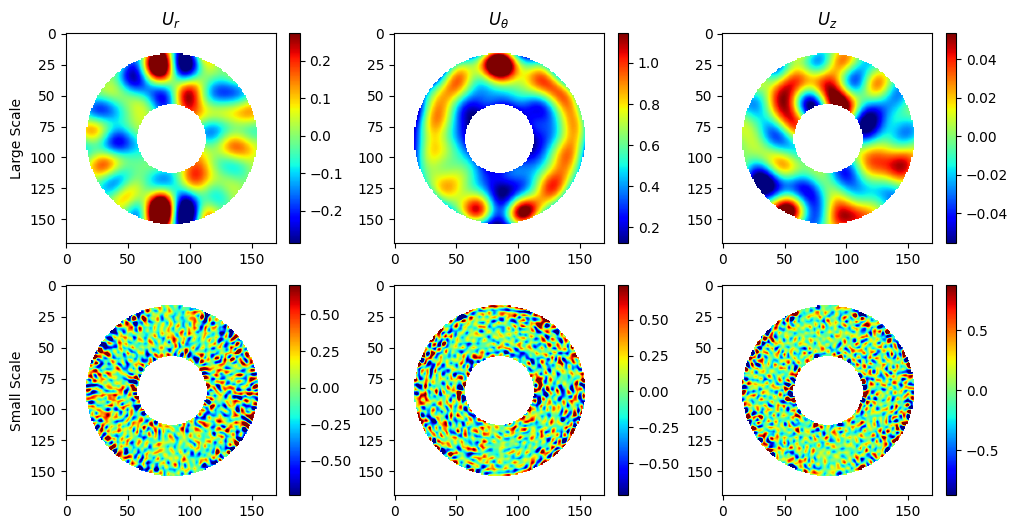

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb5994dc208>

In [260]:
UrL,UθL = xy_to_polar(ivL,jvL);
UrS,UθS = xy_to_polar(ivS,jvS);
figure(figsize=(12,6))
subplot(231);title(L"U_r");ylabel("Large Scale")
Ur2D = (A.*UrL)[:,:,1];
m,σ = mean(Ur2D[.~isnan.(Ur2D)]),std(Ur2D[.~isnan.(Ur2D)]);
imshow(Ur2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(232);title(L"U_θ")
Uθ2D = (A.*UθL)[:,:,1];
m,σ = mean(Uθ2D[.~isnan.(Uθ2D)]),std(Uθ2D[.~isnan.(Uθ2D)]);
imshow(Uθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(233);title(L"U_z")
Uz2D = (A.*kvL)[:,:,1];
m,σ = mean(Uz2D[.~isnan.(Uz2D)]),std(Uz2D[.~isnan.(Uz2D)]);
imshow(Uz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()


subplot(234);ylabel("Small Scale")
Ur2D = (A.*UrS)[:,:,1];
m,σ = mean(Ur2D[.~isnan.(Ur2D)]),std(Ur2D[.~isnan.(Ur2D)]);
imshow(Ur2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(235);
Uθ2D = (A.*UθS)[:,:,1];
m,σ = mean(Uθ2D[.~isnan.(Uθ2D)]),std(Uθ2D[.~isnan.(Uθ2D)]);
imshow(Uθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(236);
Uz2D = (A.*kvS)[:,:,1];
m,σ = mean(Uz2D[.~isnan.(Uz2D)]),std(Uz2D[.~isnan.(Uz2D)]);
imshow(Uz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()

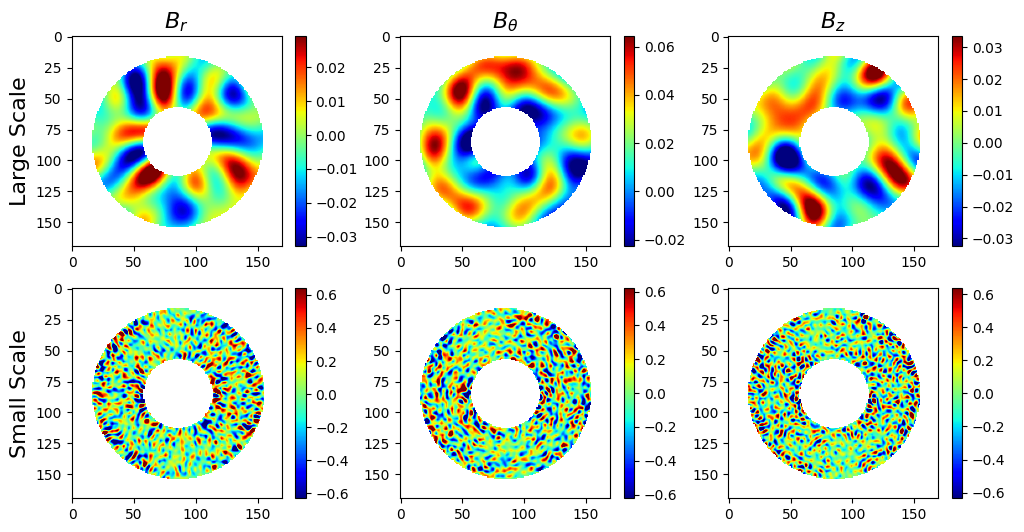

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb5990a87f0>

In [261]:
BrL,BθL = xy_to_polar(ibL,jbL);
BrS,BθS = xy_to_polar(ibS,jbS);
figure(figsize=(12,6))
subplot(231);title(L"B_r",size=16);ylabel("Large Scale",size=16)
Br2D = (A.*BrL)[:,:,1];
m,σ = mean(Br2D[.~isnan.(Ur2D)]),std(Br2D[.~isnan.(Ur2D)]);
imshow(Br2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(232);title(L"B_θ",size=16);
Bθ2D = (A.*BθL)[:,:,1];
m,σ = mean(Bθ2D[.~isnan.(Uθ2D)]),std(Bθ2D[.~isnan.(Uθ2D)]);
imshow(Bθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(233);title(L"B_z",size=16)
Bz2D = (A.*kbL)[:,:,1];
m,σ = mean(Bz2D[.~isnan.(Bz2D)]),std(Bz2D[.~isnan.(Bz2D)]);
imshow(Bz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()


subplot(234);ylabel("Small Scale",size=16)
Br2D = (A.*BrS)[:,:,1];
m,σ = mean(Br2D[.~isnan.(Br2D)]),std(Br2D[.~isnan.(Br2D)]);
imshow(Br2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(235);
Bθ2D = (A.*BθS)[:,:,1];
m,σ = mean(Bθ2D[.~isnan.(Bθ2D)]),std(Bθ2D[.~isnan.(Bθ2D)]);
imshow(Bθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
subplot(236);
Bz2D = (A.*kbS)[:,:,1];
m,σ = mean(Bz2D[.~isnan.(Bz2D)]),std(Bz2D[.~isnan.(Bz2D)]);
imshow(Bz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()

# Plotting

In [315]:
ffs = glob.glob("/mnt/c/data/MHD_Cylinder/P5DA*");
i = 0
for ff in ffs
    f = h5open(ff,"r")
    iv = read( f , "i_velocity",  ) ;
    jv = read( f , "j_velocity",  ) ;
    kv = read( f , "k_velocity",  ) ;
    ib = read( f , "i_mag_field", ) ;
    jb = read( f , "j_mag_field", ) ;
    kb = read( f , "k_mag_field", ) ;
    close(f)
    
    Ur,Uθ = xy_to_polar(iv,jv);
    figure(figsize=(12,6))
    suptitle("time = $i")
    subplot(231);title(L"U_r")
    Ur2D = (A.*Ur)[:,:,1];
    m,σ = mean(Ur2D[.~isnan.(Ur2D)]),std(Ur2D[.~isnan.(Ur2D)]);
    imshow(Ur2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
    subplot(232);title(L"U_θ")
    Uθ2D = (A.*Uθ)[:,:,1];
    m,σ = mean(Uθ2D[.~isnan.(Uθ2D)]),std(Uθ2D[.~isnan.(Uθ2D)]);
    imshow(Uθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()

    subplot(233);title(L"U_z")
    Uz2D = (A.*kv)[:,:,1];
    m,σ = mean(Uz2D[.~isnan.(Uz2D)]),std(Uz2D[.~isnan.(Uz2D)]);
    imshow(Uz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()


    Br,Bθ = xy_to_polar(ib,jb);
    subplot(234);title(L"B_r")
    Br2D = (A.*Br)[:,:,50];
    m,σ = mean(Br2D[.~isnan.(Br2D)]),std(Br2D[.~isnan.(Br2D)]);
    imshow(Br2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
    subplot(235);title(L"B_θ")
    Bθ2D = (A.*Bθ)[:,:,50];
    m,σ = mean(Bθ2D[.~isnan.(Bθ2D)]),std(Bθ2D[.~isnan.(Bθ2D)]);
    imshow(Bθ2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
    subplot(236);title(L"B_z")
    Bz2D = (A.*kb)[:,:,50];
    m,σ = mean(Bz2D[.~isnan.(Bz2D)]),std(Bz2D[.~isnan.(Bz2D)]);
    imshow(Bz2D,vmin=m-2σ,vmax=m+2σ,cmap="jet");colorbar()
    i+=1;
    savefig("/mnt/c/data/MHD_Cylinder/GIF_1/B_$i.png")
    
end

LoadError: [91mInterruptException:[39m

# Energy

In [265]:
ffs = glob.glob("/mnt/c/data/MHD_Cylinder/P5DA*");
KEr = [];
KEt = [];
KEz = [];

MEr = [];
MEt = [];
MEz = [];

mBr = [];
mBt = [];
mBz = [];

mVr = [];
mVt = [];
mVz = [];
for ff in ffs
    f = h5open(ff,"r")
    iv = read( f , "i_velocity",  ) ;
    jv = read( f , "j_velocity",  ) ;
    kv = read( f , "k_velocity",  ) ;
    ib = read( f , "i_mag_field", ) ;
    jb = read( f , "j_mag_field", ) ;
    kb = read( f , "k_mag_field", ) ;
    close(f)
    ib,jb,kb = (1 .- χ).*ib,(1 .- χ).*jb,(1 .- χ).*kb;
    iv,jv,kv = (1 .- χ).*iv,(1 .- χ).*jv,(1 .- χ).*kv;
    
    ibL,jbL,kbL = ScaleDecomposition(ib,jb,kb;kf=[1,6],Lx = 2π);
    ibS,jbS,kbS = ScaleDecomposition(ib,jb,kb;kf=[20,40],Lx = 2π);
    ivL,jvL,kvL = ScaleDecomposition(iv,jv,kv;kf=[1,6],Lx = 2π);
    ivS,jvS,kvS = ScaleDecomposition(iv,jv,kv;kf=[20,40],Lx = 2π);
    
    UrL,UθL = xy_to_polar(ivL,jvL);
    BrL,BθL = xy_to_polar(ibL,jbL);
    
    UrS,UθS = xy_to_polar(ivS,jvS);
    BrS,BθS = xy_to_polar(ibS,jbS);
    push!(mBr,sum(BrS.^2));push!(mVr,sum(UrS.^2));
    push!(mBt,sum(BθS.^2));push!(mVt,sum(UθS.^2));
    push!(mBz,sum(kbS.^2));push!(mVz,sum(kvS.^2));
    
    push!(MEr,sum(BrL.^2));push!(KEr,sum(UrL.^2));
    push!(MEt,sum(BθL.^2));push!(KEt,sum(UθL.^2));
    push!(MEz,sum(kbL.^2));push!(KEz,sum(kvL.^2));
end

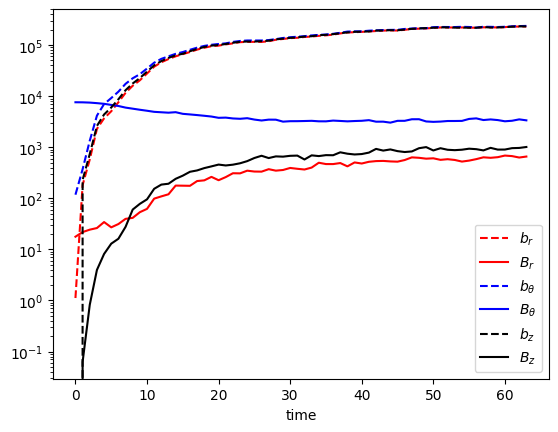

PyObject Text(0.5, 24.0, 'time')

In [312]:
plot(mBr,"r--",label=L"b_r");plot(MEr,"r-",label=L"B_r")
plot(mBt,"b--",label=L"b_\theta");plot(MEt,"b-",label=L"B_\theta")
plot(mBz,"k--",label=L"b_z");plot(MEz,"k-",label=L"B_z")
semilogy()
legend();xlabel("time")

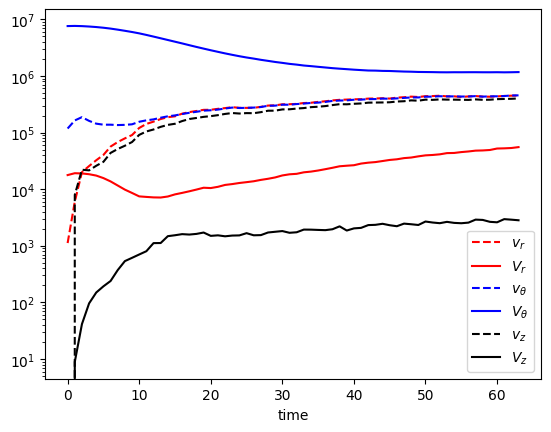

PyObject Text(0.5, 24.0, 'time')

In [311]:
plot(mVr,"r--",label=L"v_r");plot(KEr,"r-",label=L"V_r")
plot(mVt,"b--",label=L"v_\theta");plot(KEt,"b-",label=L"V_\theta")
plot(mVz,"k--",label=L"v_z");plot(KEz,"k-",label=L"V_z")
semilogy()
legend();xlabel("time")

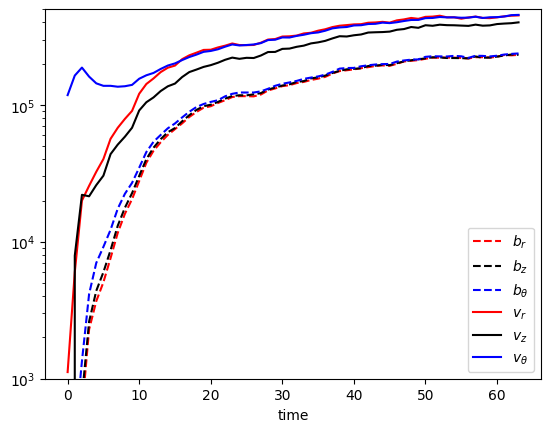

PyObject Text(0.5, 24.0, 'time')

In [310]:
plot(mBr,"r--",label=L"b_r");
plot(mBz,"k--",label=L"b_z");
plot(mBt,"b--",label=L"b_\theta");

plot(mVr,"r-",label=L"v_r");
plot(mVz,"k-",label=L"v_z");
plot(mVt,"b-",label=L"v_\theta");
semilogy();legend()
ylim(1e3,5e5);xlabel("time")

# H_m and H_k

In [307]:
Ax,Ay,Az = VectorPotential(ibL,jbL,kbL);
hm = Ax.*ib + Ay.*jb + Az.*kb;


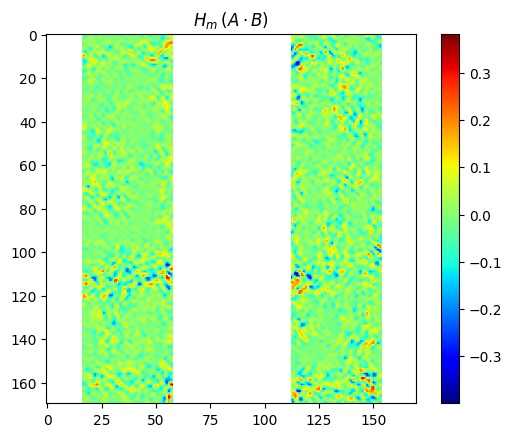

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb56179b978>

In [309]:
title(L"H_m\:(A\cdot B)")
imshow((A.*hm)[92,:,:]',cmap="jet");colorbar()

In [297]:
function hₖ(iv,jv,kv;L=2π)
# V ⋅ ( ∇ × V )
	dlx,dly,dlz  = (L/size(iv)[1]),(L/size(iv)[2]),(L/size(iv)[3]);
	dV = dlx*dly*dlz;
	cV1,cV2,cV3 = Curl(iv,jv,kv;Lx=L);
	h_k = @. (cV1*iv + cV2*jv + cV3*kv)*dV
	return h_k
end
hk = hₖ(iv,jv,kv;L=2π);

In [299]:
sum(hk),sum(hm)

(-33.95533360125788, -4159.047f0)